In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt # type: ignore

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.1.2+cu118
Numpy version: 1.24.1


##### Make classification data:

In [3]:
from sklearn.datasets import make_circles # type: ignore


# Make 1000 samples 
n_samples = 3000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.04, # a little bit of noise to the dots
                    random_state=47) # keep random state so we get the same values

In [4]:
y = y.reshape(-1, 1)

In [5]:
X.shape, y.shape

((3000, 2), (3000, 1))

In [6]:
df = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y[:, 0]})
df.head()

,x1,x2,y
0,0.247893,-0.788165,1
1,0.961860,0.325725,0
2,-0.077359,-1.066680,0
3,0.402354,0.763478,1
4,0.045377,0.775663,1


In [7]:
df.y.value_counts()

1    1500
0    1500
Name: y, dtype: int64

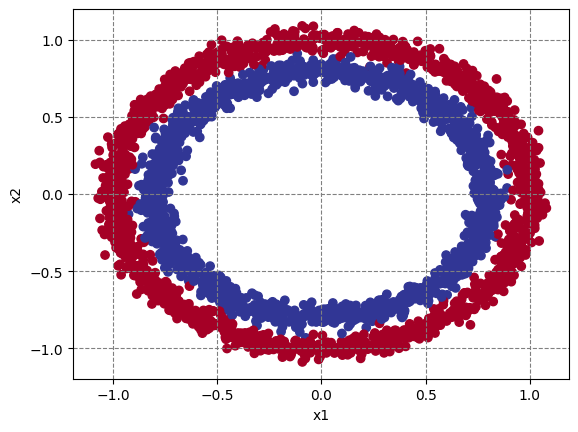

In [8]:
# now, let's plot the data
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

plt.xlabel('x1');
plt.ylabel('x2');

plt.grid(True, linestyle='--', color='gray');

plt.show();

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X.shape, y.shape

(torch.Size([3000, 2]), torch.Size([3000, 1]))

In [11]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train,
                                                    random_state=47) # make the random split reproducible

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2400, 2]),
 torch.Size([600, 2]),
 torch.Size([2400, 1]),
 torch.Size([600, 1]))

##### Building model

In [12]:
from torch import nn

In [13]:
# set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
# let's put all data into cuda
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [15]:
# let's build the model
# no non-linear activation has been used here

class CircleModelV0(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        Z1 = self.layer_1(x)
        A1 = Z1
        Z2 = self.layer_2(A1)
        A2 = Z2
        return A2

In [16]:
model_0 = CircleModelV0().to(device)

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
model_0(X_train)

tensor([[-0.3927],
        [-0.3060],
        [-0.3410],
        ...,
        [-0.3240],
        [-0.3282],
        [-0.3467]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [19]:
list(model_0.parameters())

[Parameter containing:
 tensor([[-0.3129, -0.4274],
         [ 0.5634,  0.2995],
         [-0.2127,  0.1571],
         [-0.1403,  0.1785],
         [ 0.3289,  0.0607]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.1002,  0.6510,  0.5472, -0.3517, -0.0203], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.4436, -0.3404,  0.1134, -0.3930,  0.1366]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.3666], device='cuda:0', requires_grad=True)]

In [20]:
# let's define the loss fn and the optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

In [21]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [22]:
torch.sigmoid(model_0(X_test[:5]))

tensor([[0.4099],
        [0.4024],
        [0.4125],
        [0.4058],
        [0.4137]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [23]:
torch.round(torch.sigmoid(model_0(X_test[:5])))

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [24]:
y_pred = torch.round(torch.sigmoid(model_0(X_test)))

correct = torch.eq(y_test, y_pred).sum().item()
correct

308

In [25]:
acc = correct / y_test.shape[0]
acc

0.5133333333333333

In [26]:
y_train = torch.squeeze(y_train)
y_test = torch.squeeze(y_test)

y_train.shape, y_test.shape

(torch.Size([2400]), torch.Size([600]))

In [27]:
# let's define the training loop

def training_loop(X_train, y_train, X_test, y_test, loss_fn, optimizer, n_iterations, model):
    
    # Create empty loss lists to track values
    train_loss_values = []
    test_loss_values = []
    
    # Build training and evaluation loop
    for epoch in range(n_iterations):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
    
        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                    y_train) 
        
        acc = accuracy_fn(y_true=y_train, 
                        y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

        # Print out what's happening every 10 epochs
        if (epoch % 10 == 0):
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
        
                # Save the loss values (move them to CPU before converting to NumPy)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
    
    return train_loss_values, test_loss_values

In [28]:
n_iterations = 200

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_0.parameters(),
                                    lr=0.01
                                ),
                                n_iterations=n_iterations, 
                                model=model_0)

Epoch: 0 | Loss: 0.70928, Accuracy: 49.67% | Test loss: 0.70371, Test acc: 51.33%

Epoch: 10 | Loss: 0.70753, Accuracy: 49.67% | Test loss: 0.70235, Test acc: 51.33%

Epoch: 20 | Loss: 0.70597, Accuracy: 49.67% | Test loss: 0.70117, Test acc: 51.33%

Epoch: 30 | Loss: 0.70458, Accuracy: 49.67% | Test loss: 0.70013, Test acc: 51.33%

Epoch: 40 | Loss: 0.70334, Accuracy: 49.67% | Test loss: 0.69923, Test acc: 51.33%

Epoch: 50 | Loss: 0.70224, Accuracy: 49.67% | Test loss: 0.69844, Test acc: 51.33%

Epoch: 60 | Loss: 0.70126, Accuracy: 49.67% | Test loss: 0.69775, Test acc: 51.33%

Epoch: 70 | Loss: 0.70038, Accuracy: 49.67% | Test loss: 0.69715, Test acc: 51.33%

Epoch: 80 | Loss: 0.69961, Accuracy: 49.67% | Test loss: 0.69663, Test acc: 51.33%

Epoch: 90 | Loss: 0.69892, Accuracy: 49.67% | Test loss: 0.69618, Test acc: 51.33%

Epoch: 100 | Loss: 0.69831, Accuracy: 49.67% | Test loss: 0.69579, Test acc: 51.33%

Epoch: 110 | Loss: 0.69776, Accuracy: 49.67% | Test loss: 0.69546, Test acc:

In [29]:
def plot_loss_curves(epochs, train_loss_values, test_loss_values):
    # Create a figure with size 6x4 inches
    plt.figure(figsize=(6, 4))
    
    # Plot the training and test loss values
    plt.plot(range(epochs), train_loss_values, label="Train loss")
    plt.plot(range(epochs), test_loss_values, label="Test loss")
    
    # Set the title and labels
    plt.title("Training and Test Loss Curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    # Add a legend
    plt.legend()
    
    # Add a grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

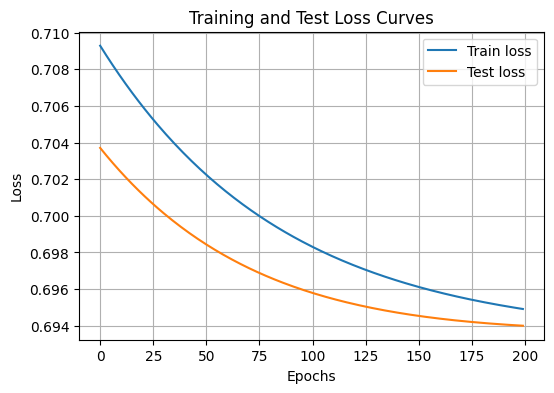

In [30]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [31]:
# let's add non-linearity of the model_0

class CircleModelV1(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x):
        # First layer with tanh activation (non-linearity)
        Z1 = self.layer_1(x)
        #A1 = torch.tanh(Z1)
        A1 = torch.relu(Z1)
        
        # Second layer (no activation here, since BCEWithLogitsLoss expects raw logits)
        Z2 = self.layer_2(A1)
        
        return Z2

In [32]:
model_1 = CircleModelV1().to(device)

In [33]:
n_iterations = 2000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_1.parameters(),
                                    lr=0.1
                                ),
                                n_iterations=n_iterations, 
                                model=model_1)

Epoch: 0 | Loss: 0.69616, Accuracy: 51.17% | Test loss: 0.69725, Test acc: 51.17%

Epoch: 10 | Loss: 0.69486, Accuracy: 50.67% | Test loss: 0.69543, Test acc: 50.50%

Epoch: 20 | Loss: 0.69399, Accuracy: 50.88% | Test loss: 0.69426, Test acc: 50.50%

Epoch: 30 | Loss: 0.69332, Accuracy: 50.88% | Test loss: 0.69344, Test acc: 50.00%

Epoch: 40 | Loss: 0.69276, Accuracy: 50.83% | Test loss: 0.69279, Test acc: 50.50%

Epoch: 50 | Loss: 0.69226, Accuracy: 50.83% | Test loss: 0.69227, Test acc: 50.33%

Epoch: 60 | Loss: 0.69181, Accuracy: 50.88% | Test loss: 0.69181, Test acc: 50.50%

Epoch: 70 | Loss: 0.69139, Accuracy: 50.88% | Test loss: 0.69140, Test acc: 51.33%

Epoch: 80 | Loss: 0.69100, Accuracy: 51.29% | Test loss: 0.69102, Test acc: 51.67%

Epoch: 90 | Loss: 0.69062, Accuracy: 51.42% | Test loss: 0.69067, Test acc: 51.83%

Epoch: 100 | Loss: 0.69025, Accuracy: 51.67% | Test loss: 0.69033, Test acc: 52.00%

Epoch: 110 | Loss: 0.68989, Accuracy: 51.88% | Test loss: 0.69000, Test acc:

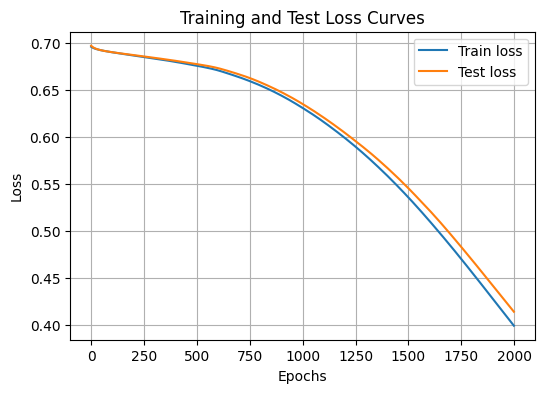

In [34]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [35]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.1235, -0.0924],
                      [ 2.6633,  0.1947],
                      [-0.9719,  2.4086],
                      [ 0.5090, -0.1465],
                      [ 0.0939,  0.2322],
                      [-1.4881, -2.2815],
                      [ 0.0674, -0.0412],
                      [ 1.5230, -1.1546]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2954, -0.3553,  0.0494,  1.5617,  0.7209, -0.2497,  0.9933, -0.3759],
                     device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2832, -2.6210, -2.4604,  1.5746,  0.5461, -2.6442,  0.9348, -1.8215]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([2.0628], device='cuda:0'))])

In [36]:
from helper_functions import plot_predictions, plot_decision_boundary

In [37]:

def plot_train_test_boundaries(model, X_train, y_train, X_test, y_test):
    """
    Plots decision boundaries for both training and test sets.
    
    Args:
        model: The trained model used for prediction.
        X_train: Training data features.
        y_train: Training data labels.
        X_test: Test data features.
        y_test: Test data labels.
    """
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot decision boundary for the training set
    plt.subplot(1, 2, 1)
    plt.title("Training Set Decision Boundary")
    plot_decision_boundary(model, X_train, y_train)
    plt.xlabel("x1")
    plt.ylabel("x2")

    # Plot decision boundary for the test set
    plt.subplot(1, 2, 2)
    plt.title("Test Set Decision Boundary")
    plot_decision_boundary(model, X_test, y_test)
    plt.xlabel("x1")
    plt.ylabel("x2")

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


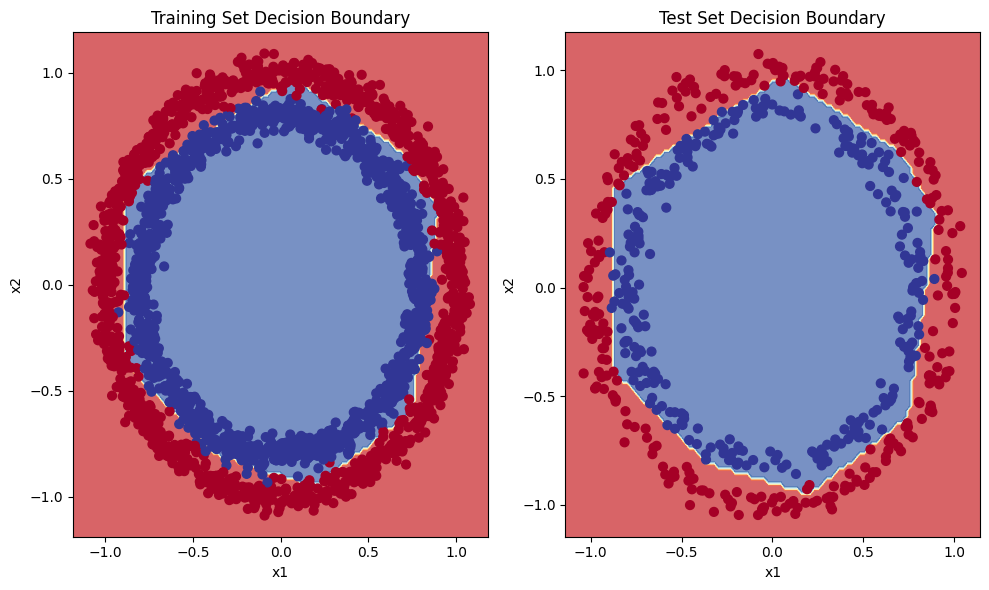

In [38]:
# Example usage
plot_train_test_boundaries(model_1, X_train, y_train, X_test, y_test)

In [39]:

class CircleModelV2(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x):
        # First layer with relu activation (non-linearity)
        Z1 = self.layer_1(x)
        A1 = torch.relu(Z1)
        
        # Second layer with relu activation
        Z2 = self.layer_2(A1)
        A2 = torch.relu(Z2)
        
        # third layer (output layer) (no activation here, since BCEWithLogitsLoss expects raw logits) 
        Z3 = self.layer_3(A2)
        
        return Z3

In [40]:
model_2 = CircleModelV2().to(device)
list(model_2.parameters())

[Parameter containing:
 tensor([[-0.0781, -0.0204],
         [ 0.4043, -0.4136],
         [ 0.0842,  0.4245],
         [ 0.6881,  0.1452],
         [ 0.3569, -0.6851],
         [ 0.3720, -0.6069],
         [ 0.1668, -0.4929],
         [-0.6361, -0.0167],
         [ 0.5218,  0.6586],
         [-0.6789, -0.6590],
         [ 0.5176, -0.4394],
         [-0.1532, -0.0234],
         [-0.3138,  0.5658],
         [ 0.6289, -0.1147],
         [-0.4357,  0.6063],
         [-0.4658, -0.3470]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.2610, -0.5071, -0.5562,  0.6387, -0.5835, -0.2001,  0.3037, -0.2458,
          0.2842,  0.0232, -0.5384,  0.5586, -0.1311,  0.3328, -0.5292,  0.2228],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 9.3799e-02, -2.0163e-01, -9.2088e-02,  1.3711e-01, -1.4778e-01,
          -2.3475e-01, -1.4465e-01, -6.9855e-02, -1.0482e-01,  2.4486e-01,
          -2.4291e-01, -1.6519e-01, -4.3025e-02, -1.7005e-01,  1.5911

In [41]:
n_iterations = 1000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_2.parameters(),
                                    lr=0.1
                                ),
                                n_iterations=n_iterations, 
                                model=model_2)

Epoch: 0 | Loss: 0.71584, Accuracy: 49.67% | Test loss: 0.70659, Test acc: 51.33%

Epoch: 10 | Loss: 0.70450, Accuracy: 49.67% | Test loss: 0.69815, Test acc: 51.33%

Epoch: 20 | Loss: 0.69867, Accuracy: 49.67% | Test loss: 0.69420, Test acc: 51.33%

Epoch: 30 | Loss: 0.69555, Accuracy: 49.67% | Test loss: 0.69234, Test acc: 51.33%

Epoch: 40 | Loss: 0.69377, Accuracy: 49.67% | Test loss: 0.69146, Test acc: 51.33%

Epoch: 50 | Loss: 0.69270, Accuracy: 49.67% | Test loss: 0.69102, Test acc: 51.33%

Epoch: 60 | Loss: 0.69198, Accuracy: 49.67% | Test loss: 0.69075, Test acc: 51.33%

Epoch: 70 | Loss: 0.69142, Accuracy: 49.67% | Test loss: 0.69050, Test acc: 51.33%

Epoch: 80 | Loss: 0.69080, Accuracy: 50.62% | Test loss: 0.69013, Test acc: 53.50%

Epoch: 90 | Loss: 0.69040, Accuracy: 57.17% | Test loss: 0.68993, Test acc: 59.67%

Epoch: 100 | Loss: 0.69011, Accuracy: 59.71% | Test loss: 0.68978, Test acc: 61.17%

Epoch: 110 | Loss: 0.68982, Accuracy: 59.75% | Test loss: 0.68960, Test acc:

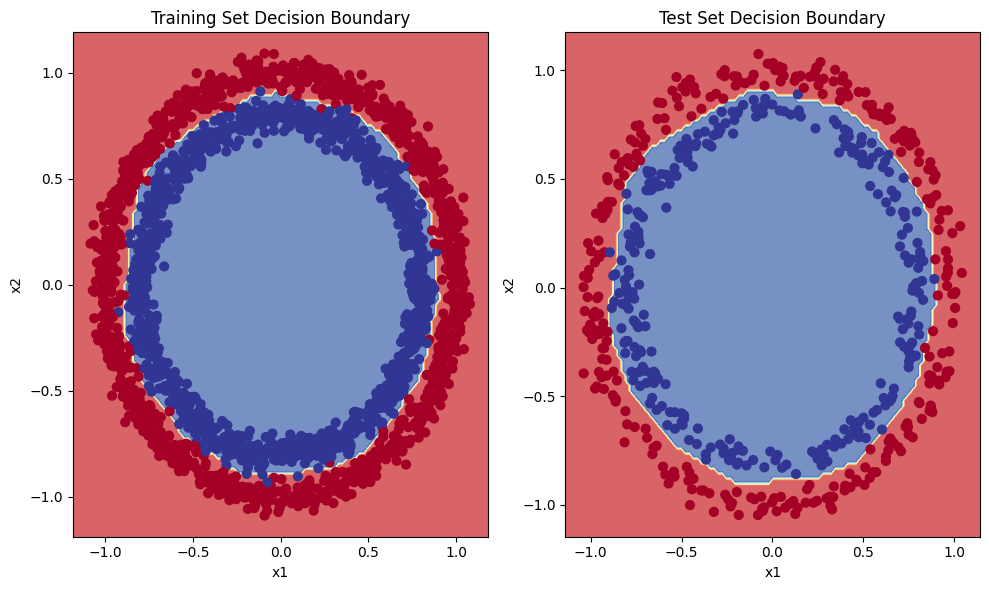

In [42]:
# Example usage
plot_train_test_boundaries(model_2, X_train, y_train, X_test, y_test)

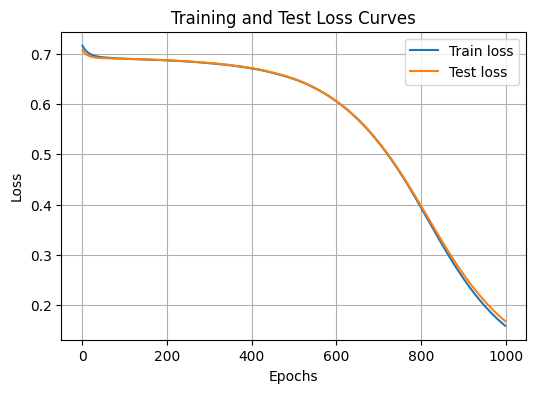

In [43]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [44]:

class CircleModelV3(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        # Define a deeper architecture with more neurons
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        #self.layer_4 = nn.Linear(in_features=16, out_features=1)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Pass through each layer with ReLU activations
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        # x = self.relu(self.layer_3(x))
        
        # Final layer (logits, no activation as BCEWithLogitsLoss expects raw logits)
        x = self.layer_3(x)
        return x

In [45]:
model_3 = CircleModelV3().to(device)
list(model_3.parameters())

[Parameter containing:
 tensor([[-0.5431,  0.0944],
         [-0.4748, -0.1381],
         [-0.4234, -0.5952],
         [-0.0251, -0.1546],
         [-0.3990, -0.3457],
         [-0.6098,  0.1607],
         [ 0.0299, -0.2858],
         [-0.2798, -0.5786],
         [ 0.4256, -0.1280],
         [-0.3423, -0.6897]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0766, -0.1658,  0.5850, -0.3431,  0.6316, -0.2626,  0.3372,  0.0949,
          0.6223,  0.3737], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.1317, -0.1321, -0.1762,  0.1291,  0.0880,  0.3089,  0.1645, -0.1757,
          -0.2560, -0.2373],
         [-0.0397, -0.0156,  0.2261,  0.1941, -0.0570,  0.2595, -0.2911, -0.2615,
           0.0420,  0.0720],
         [ 0.1538,  0.3120,  0.1614,  0.1518,  0.1230, -0.0761, -0.0342, -0.1137,
          -0.1516, -0.3054],
         [ 0.2553,  0.1253, -0.2581, -0.2674, -0.2637, -0.0569,  0.0146, -0.1949,
          -0.0863, -0.0483],
         [-

In [46]:
n_iterations = 1000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_3.parameters(),
                                    lr=0.1
                                ),
                                n_iterations=n_iterations, 
                                model=model_3)

Epoch: 0 | Loss: 0.69432, Accuracy: 42.71% | Test loss: 0.69311, Test acc: 43.17%

Epoch: 10 | Loss: 0.69387, Accuracy: 47.46% | Test loss: 0.69303, Test acc: 48.00%

Epoch: 20 | Loss: 0.69358, Accuracy: 49.21% | Test loss: 0.69300, Test acc: 48.83%

Epoch: 30 | Loss: 0.69338, Accuracy: 49.75% | Test loss: 0.69298, Test acc: 47.83%

Epoch: 40 | Loss: 0.69321, Accuracy: 50.33% | Test loss: 0.69295, Test acc: 47.83%

Epoch: 50 | Loss: 0.69306, Accuracy: 50.71% | Test loss: 0.69290, Test acc: 49.33%

Epoch: 60 | Loss: 0.69293, Accuracy: 51.00% | Test loss: 0.69284, Test acc: 50.33%

Epoch: 70 | Loss: 0.69280, Accuracy: 51.08% | Test loss: 0.69277, Test acc: 50.00%

Epoch: 80 | Loss: 0.69267, Accuracy: 51.75% | Test loss: 0.69270, Test acc: 50.50%

Epoch: 90 | Loss: 0.69255, Accuracy: 51.96% | Test loss: 0.69261, Test acc: 51.17%

Epoch: 100 | Loss: 0.69242, Accuracy: 51.96% | Test loss: 0.69253, Test acc: 51.50%

Epoch: 110 | Loss: 0.69230, Accuracy: 52.25% | Test loss: 0.69244, Test acc:

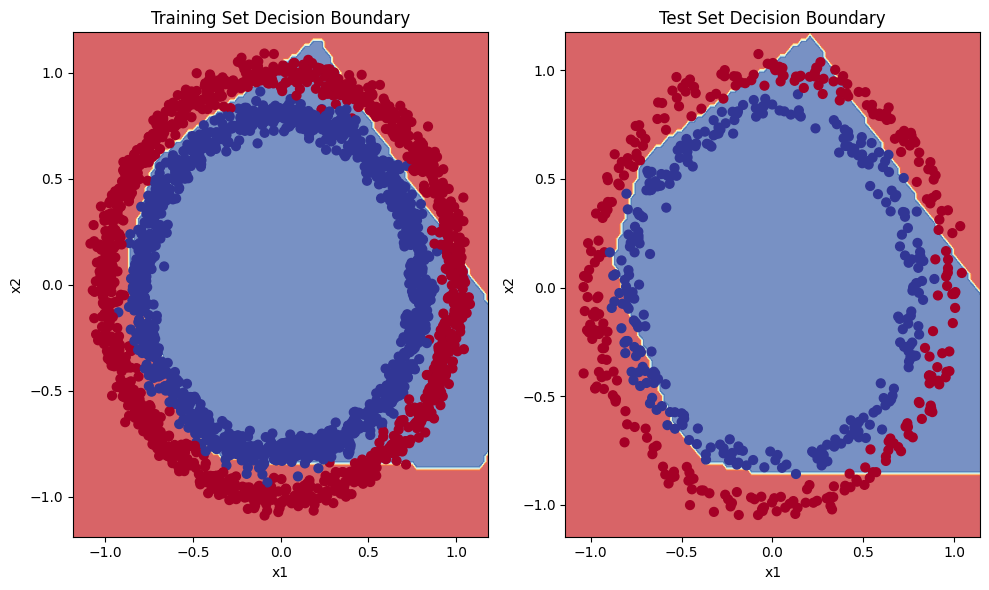

In [47]:
# Example usage
plot_train_test_boundaries(model_3, X_train, y_train, X_test, y_test)

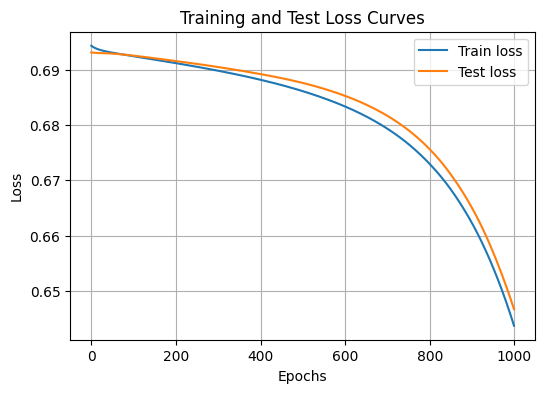

In [48]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)